In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree
from time import time
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.neighbors import KernelDensity

# Country Data from HELP International

In [3]:
# dataset directory https://www.kaggle.com/datasets/rohan0301/unsupervised-learning-on-country-data/data

country_src = '/content/Country-data.csv'

In [67]:
country_df = pd.read_csv(country_src)
display(country_df)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200
...,...,...,...,...,...,...,...,...,...,...
162,Vanuatu,29.2,46.6,5.25,52.7,2950,2.62,63.0,3.50,2970
163,Venezuela,17.1,28.5,4.91,17.6,16500,45.90,75.4,2.47,13500
164,Vietnam,23.3,72.0,6.84,80.2,4490,12.10,73.1,1.95,1310
165,Yemen,56.3,30.0,5.18,34.4,4480,23.60,67.5,4.67,1310


In [68]:
scaler = StandardScaler()
X = scaler.fit_transform(country_df.drop(columns=['country']))

## K-Means Elbow Plot and Silhouette Score Plot

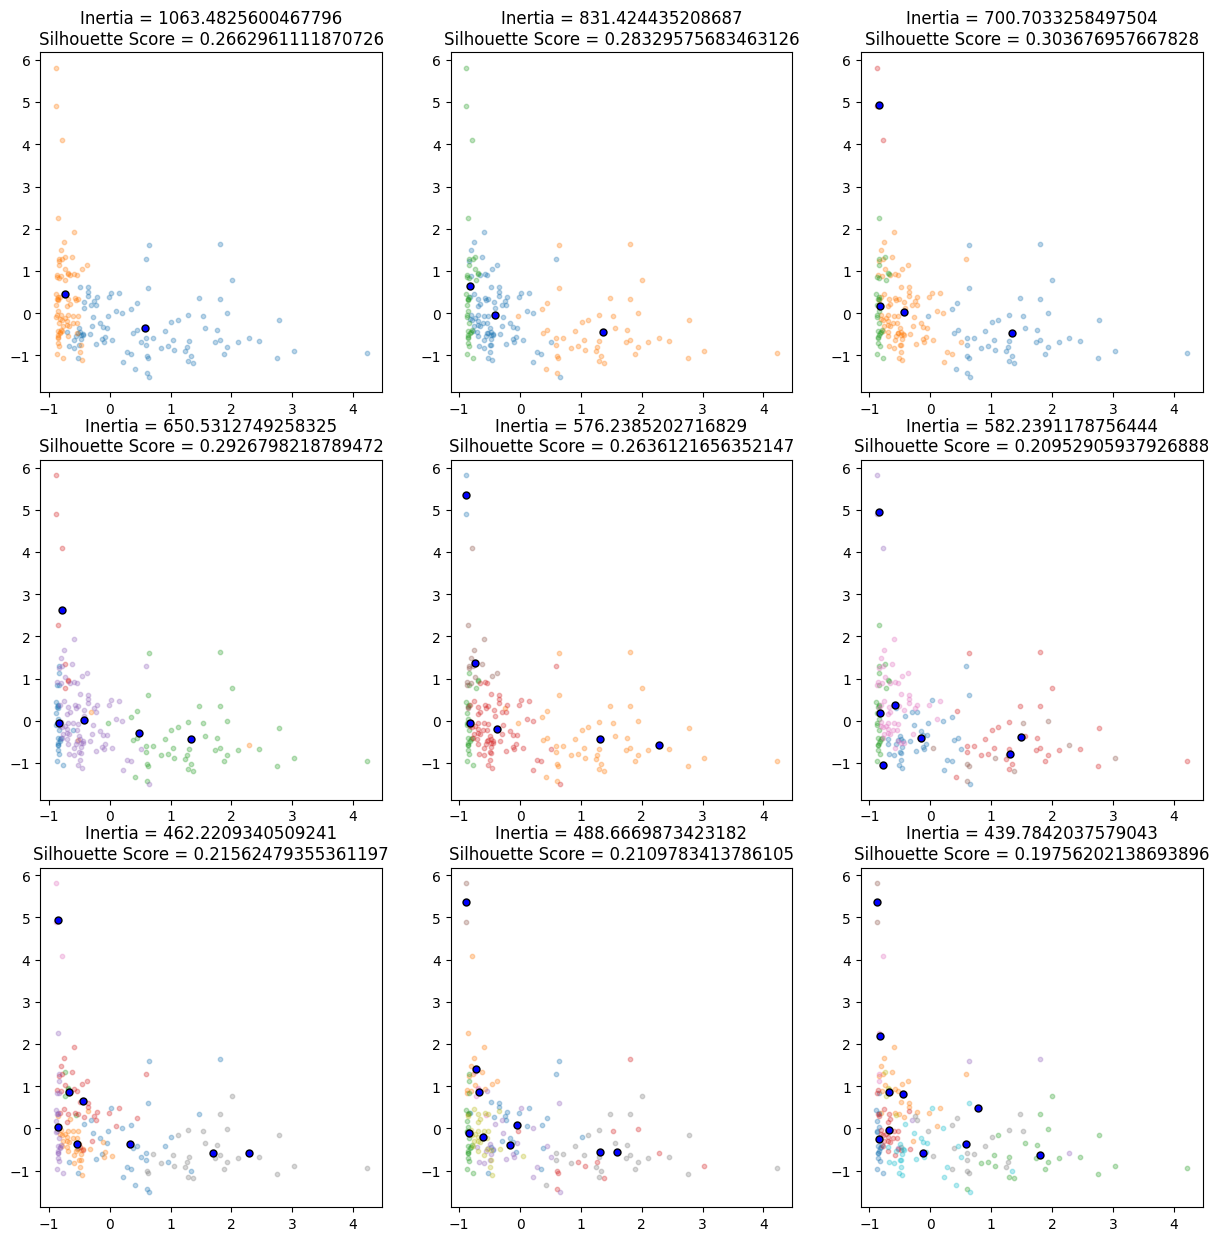

In [69]:
inertia_values = []
silhouette_avgs = []
fig2 = plt.figure(figsize=(15,15))
for i in range(2,11):
    kmeans = KMeans(n_clusters=i, n_init='auto').fit(X)
    cluster_labels = kmeans.labels_
    centroids = kmeans.cluster_centers_
    inertia_values.append(kmeans.inertia_)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_avgs.append(silhouette_avg)
    ax = fig2.add_subplot(330 + i - 1)
    for j in range(0,i):
        ax.scatter(X[cluster_labels == j,0], X[cluster_labels == j,1], s=10, alpha=0.3)
    ax.scatter(centroids[:,0],centroids[:,1], s=25, color='b', edgecolor='k')
    ax.set_title(f"Inertia = {kmeans.inertia_}\nSilhouette Score = {silhouette_avg}")

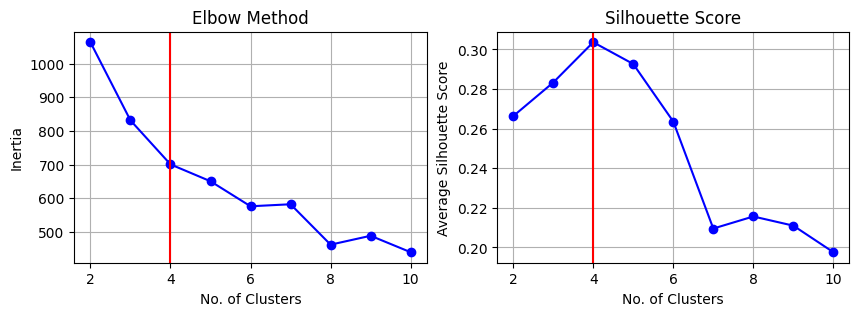

The number of clusters recommended is 4


In [70]:
max_val = max(silhouette_avgs)
x = silhouette_avgs.index(max_val) + 2

plt.figure(figsize=(10,3))
plt.subplot(121)
plt.plot(np.arange(2,11),inertia_values,'o-b')
plt.axvline(x=x, color = 'r')
plt.grid()
plt.xlabel('No. of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.subplot(122)
plt.plot(np.arange(2,11),silhouette_avgs,'o-b')
plt.axvline(x=x, color = 'r')
plt.grid()
plt.xlabel('No. of Clusters')
plt.ylabel('Average Silhouette Score')
plt.title('Silhouette Score')
plt.show()

print("The number of clusters recommended is " + str(x))

## Hierarchical Clustering

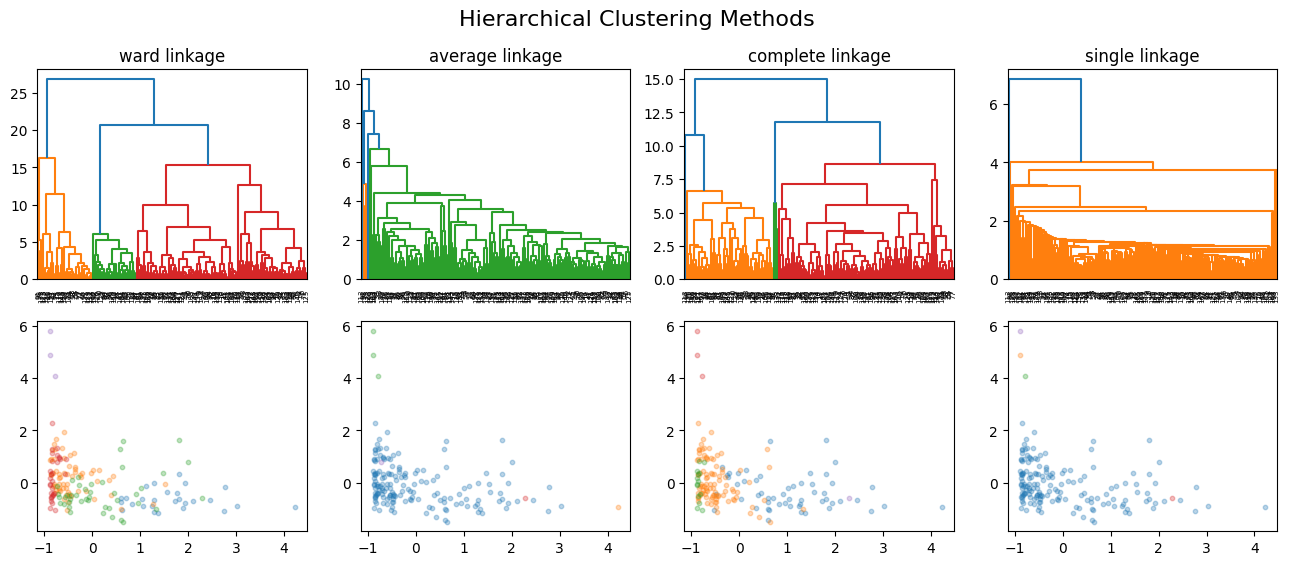

Elapsed Time: 8.00176191329956 sec


In [8]:
fig = plt.figure(figsize=(16,6))
plt.suptitle('Hierarchical Clustering Methods', fontsize=16)
ctr = 1
t0 = time()
for method in ('ward', 'average', 'complete', 'single'):
    Z = linkage(X, method=method)
    ax = fig.add_subplot(240 + ctr)
    ax.set_title("%s linkage" % method)
    dendrogram(Z)
    cutree = cut_tree(Z, n_clusters=5).flatten()
    ax = fig.add_subplot(240 + ctr + 4)
    for j in range(0,5):
        ax.scatter(X[cutree == j,0], X[cutree == j,1], s=10, alpha=0.3)
    ctr += 1

plt.show()
print(f"Elapsed Time: {time()-t0} sec")

The recommended hierarchical clustering method is the ward method because its dendogram shows clear distiction between the different classified clusters, supported by the distinguishable lengths of the main branching stems of the dendogram.

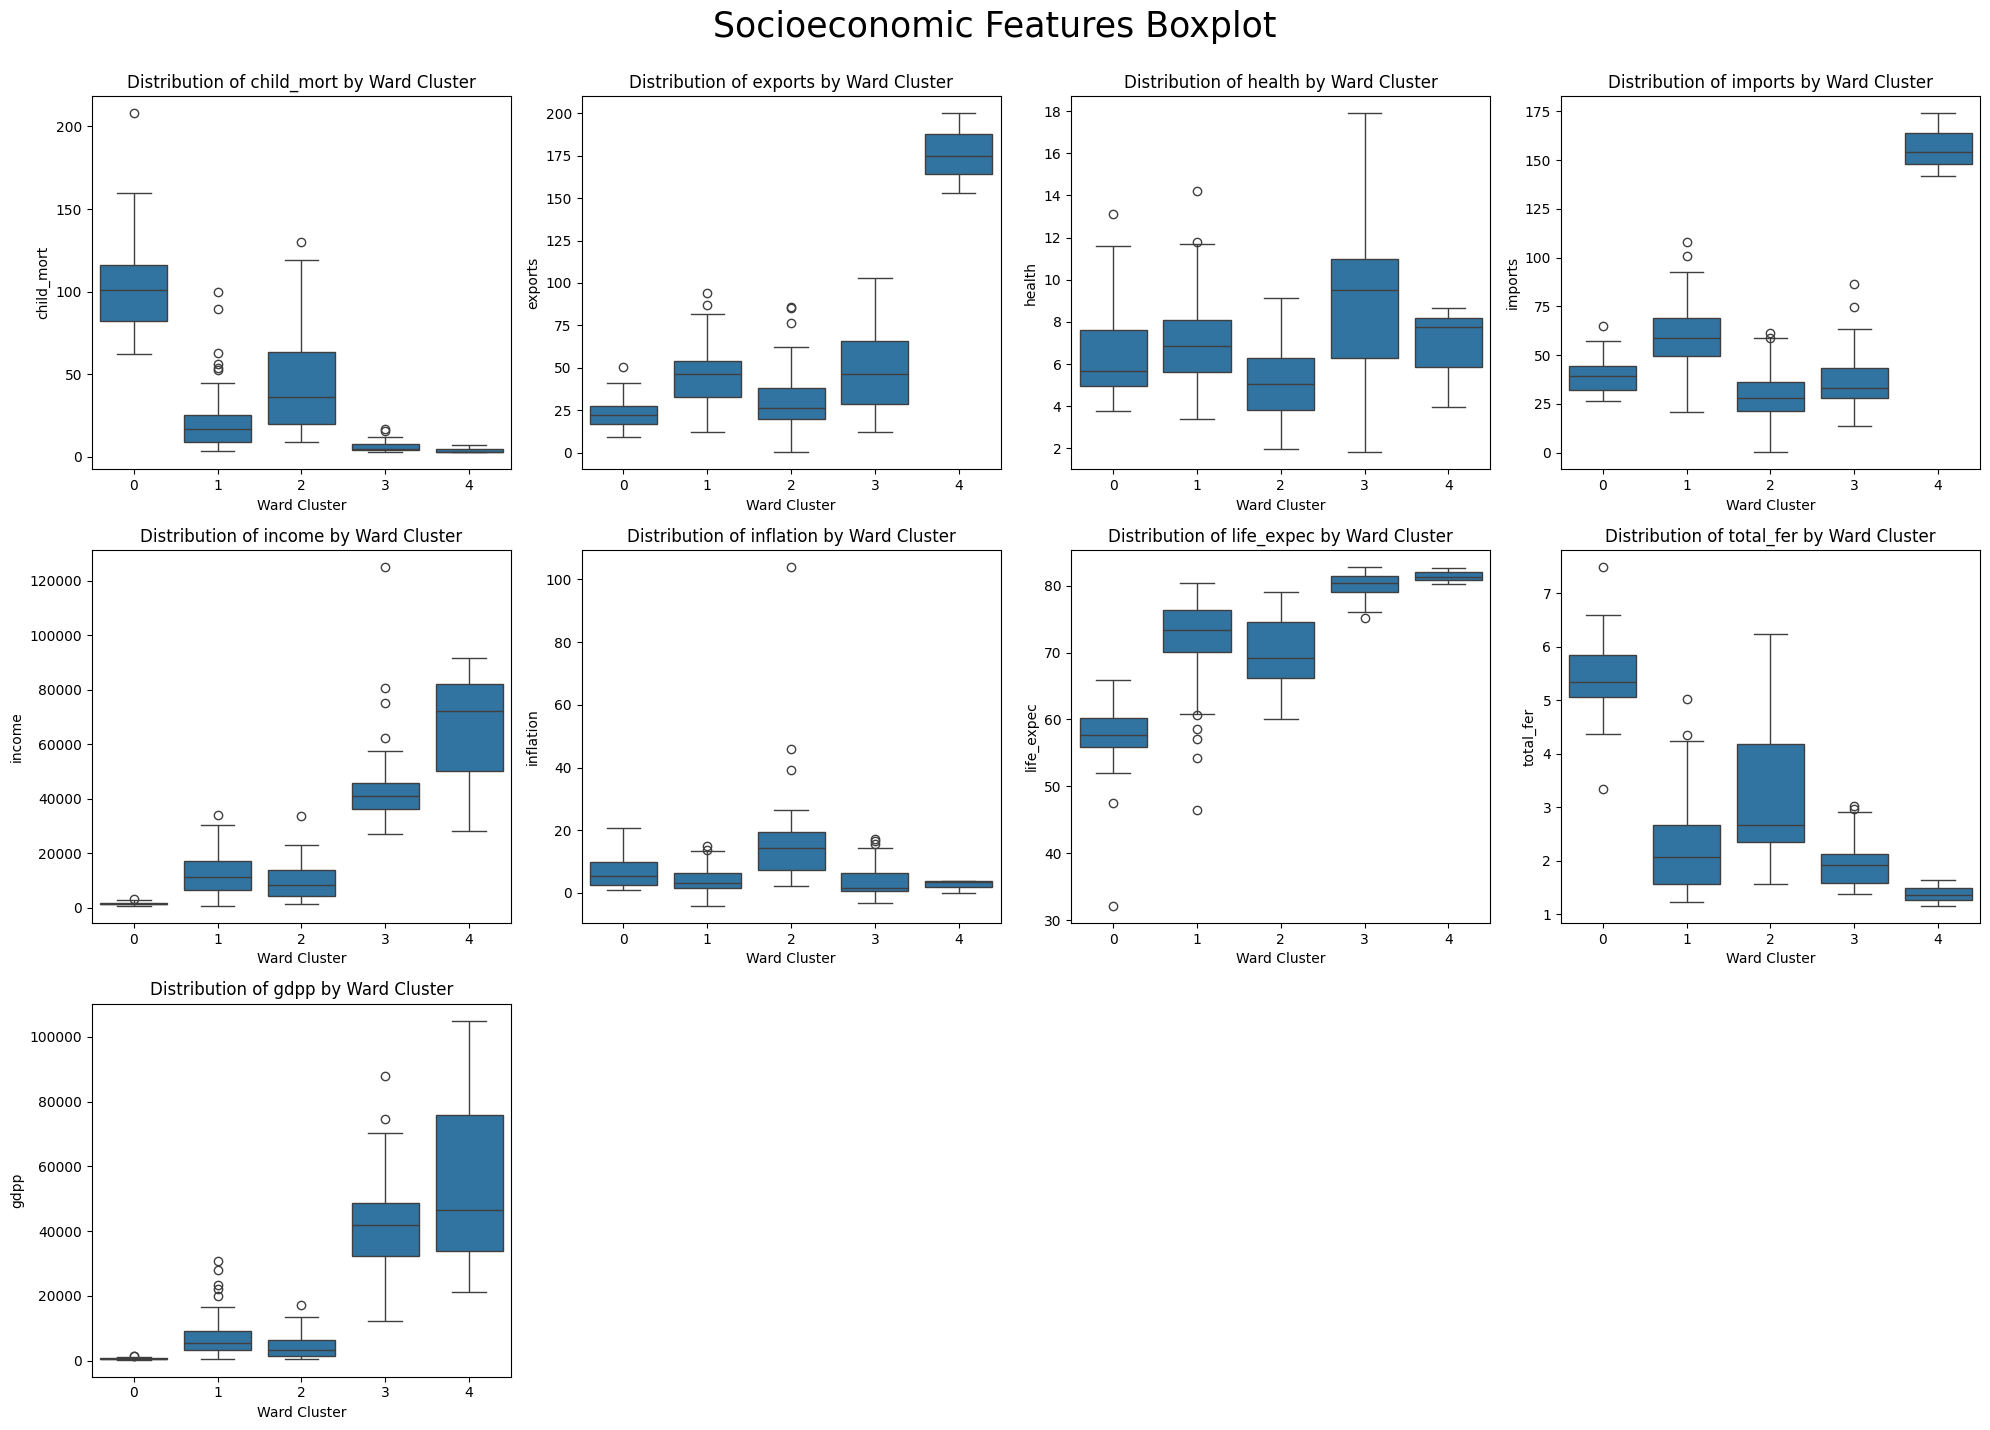

In [9]:
Z_ward = linkage(X, method='ward')
ward_cluster_labels = cut_tree(Z_ward, n_clusters=5).flatten()

temp_plot_df = country_df.drop(columns=['country']).copy()
temp_plot_df['Ward_Cluster'] = ward_cluster_labels

numerical_features = temp_plot_df.drop(columns=['Ward_Cluster']).columns

num_features = len(numerical_features);
rows = (num_features + 3) // 4
plt.figure(figsize=(20, 5 * rows))
plt.suptitle('Socioeconomic Features Boxplot', fontsize=25)

for i, feature in enumerate(numerical_features):
    plt.subplot(rows, 4, i + 1)
    sns.boxplot(x='Ward_Cluster', y=feature, data=temp_plot_df)
    plt.title(f'Distribution of {feature} by Ward Cluster')
    plt.xlabel('Ward Cluster')
    plt.ylabel(feature)

plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

Given the Ward Hierarchical Clustering with 5 recommended clusters, each feature of the dataset is visualized through the box plots above.

Cluster 0 shows severely underdeveloped nations with the highest child mortality and total fertility, and the lowest income, life expectancy, and GDP.

Cluster 4 on the other hand indicates first world nations with opposite metrics with Cluster 0, but also with the highest imports, exports, and health metrics.

Other clusters rest in between with transitional socioeconomic performances.

## PCA + K-means

/tmp/ipython-input-4115189404.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], cmap=plt.cm.Spectral)


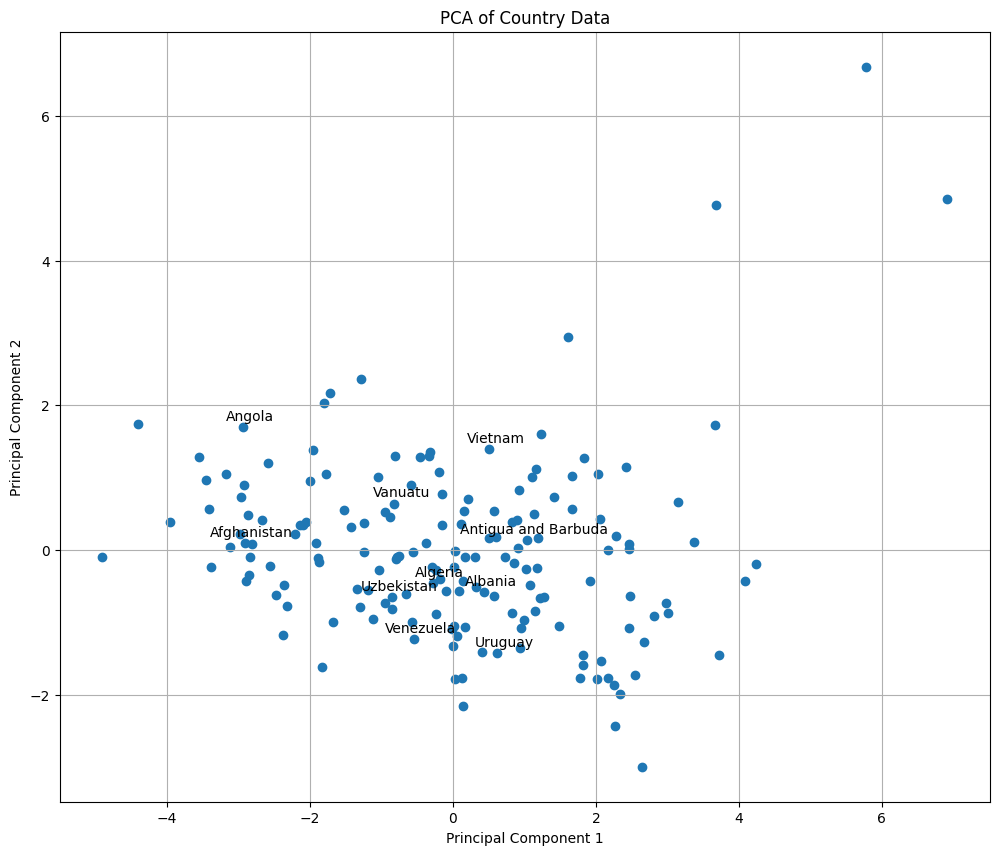

In [10]:
pca = PCA()

X_pca = pca.fit_transform(X)

plt.figure(figsize=(12, 10))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], cmap=plt.cm.Spectral)
plt.title('PCA of Country Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

countries_to_label_indices = [0, 1, 2, 3, 4, 160, 161, 162, 163, 164]
for i in countries_to_label_indices:
    plt.annotate(country_df['country'].iloc[i], (X_pca[i, 0], X_pca[i, 1]), textcoords="offset points", xytext=(5,5), ha='center')

plt.grid(True)
plt.show()

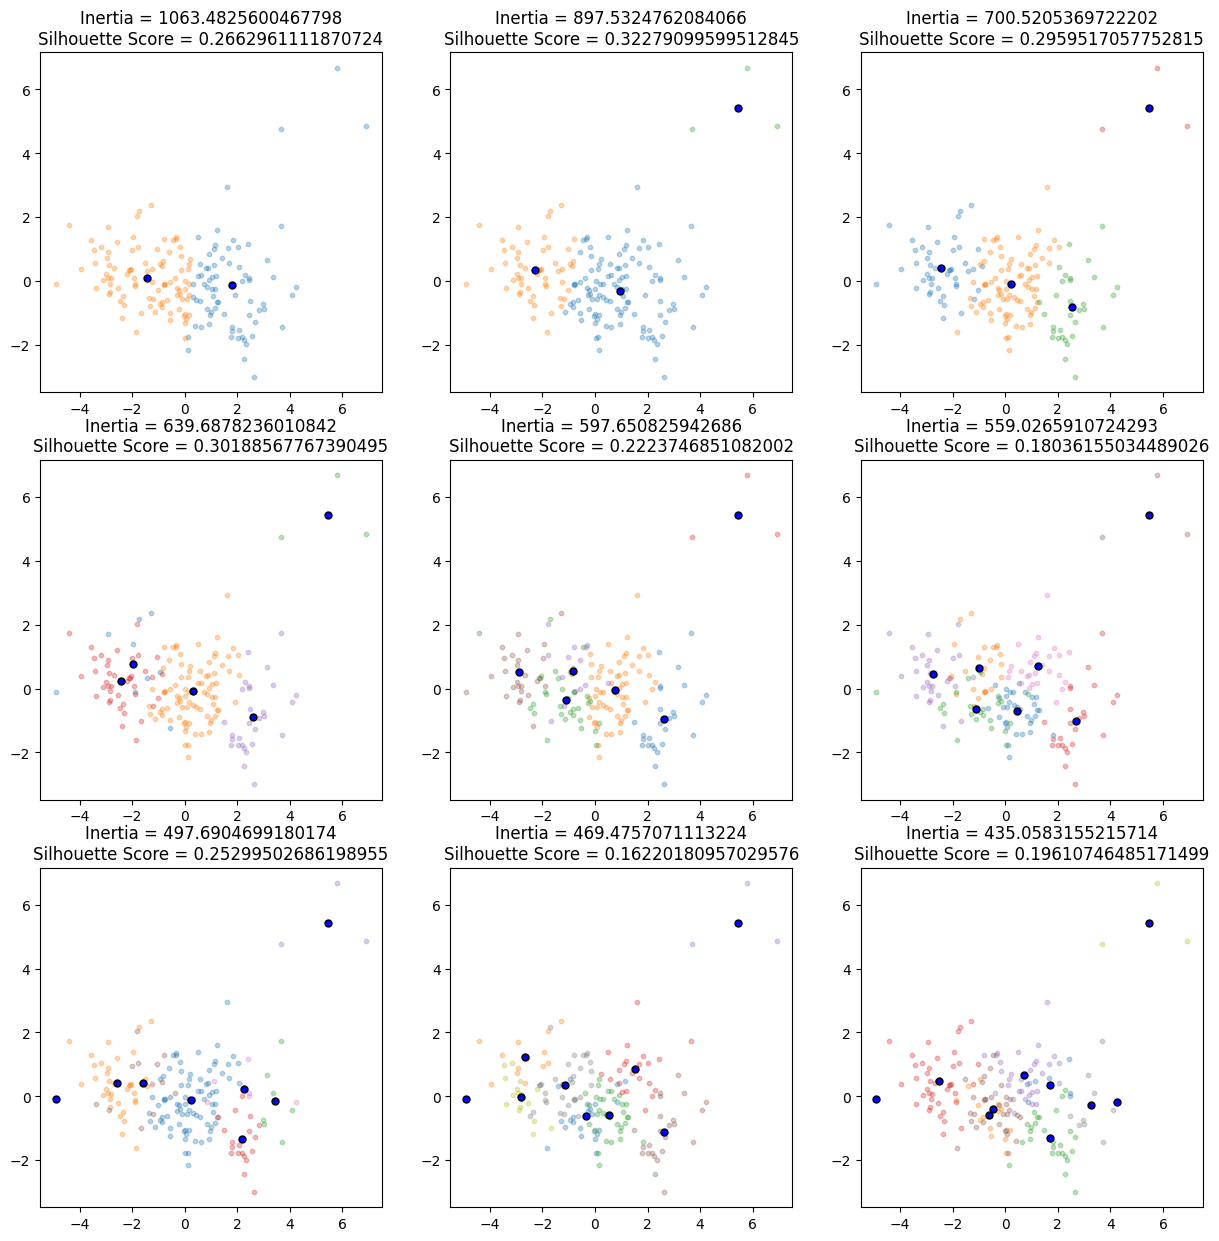

In [11]:
inertia_values = []
silhouette_avgs = []
fig2 = plt.figure(figsize=(15,15))
for i in range(2,11):
    kmeans = KMeans(n_clusters=i, n_init='auto').fit(X_pca)
    cluster_labels = kmeans.labels_
    centroids = kmeans.cluster_centers_
    inertia_values.append(kmeans.inertia_)
    silhouette_avg = silhouette_score(X_pca, cluster_labels)
    silhouette_avgs.append(silhouette_avg)
    ax = fig2.add_subplot(330 + i - 1)
    for j in range(0,i):
        ax.scatter(X_pca[cluster_labels == j,0], X_pca[cluster_labels == j,1], s=10, alpha=0.3)
    ax.scatter(centroids[:,0],centroids[:,1], s=25, color='b', edgecolor='k')
    ax.set_title(f"Inertia = {kmeans.inertia_}\nSilhouette Score = {silhouette_avg}")

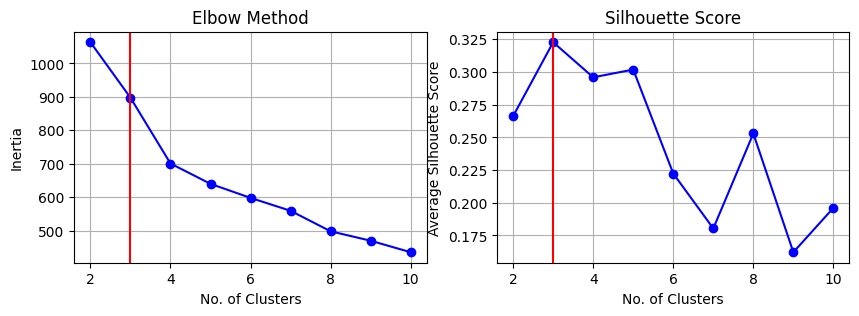

The number of clusters recommended is 3


In [12]:
max_val = max(silhouette_avgs)
x = silhouette_avgs.index(max_val) + 2

plt.figure(figsize=(10,3))
plt.subplot(121)
plt.plot(np.arange(2,11),inertia_values,'o-b')
plt.axvline(x=x, color = 'r')
plt.grid()
plt.xlabel('No. of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.subplot(122)
plt.plot(np.arange(2,11),silhouette_avgs,'o-b')
plt.axvline(x=x, color = 'r')
plt.grid()
plt.xlabel('No. of Clusters')
plt.ylabel('Average Silhouette Score')
plt.title('Silhouette Score')
plt.show()

print("The number of clusters recommended is " + str(x))

## PCA Anomaly Detection

Threshold (KDE) = 0.008372457541949301


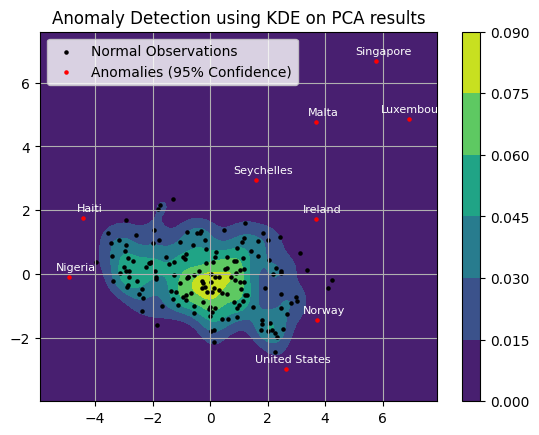

In [13]:
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
Xp, Yp = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
XY = np.vstack([Xp.ravel(), Yp.ravel()]).T

kde = KernelDensity(kernel='gaussian',bandwidth=0.4).fit(X_pca[:, :2])
Zp = np.exp(kde.score_samples(XY))
Zp = Zp.reshape(Xp.shape)

scores = kde.score_samples(X_pca[:, :2])
threshold = np.quantile(scores,0.05)
print(f"Threshold (KDE) = {np.exp(threshold)}")

anomalous_indices = np.where(scores <= threshold)[0]
anomals = X_pca[anomalous_indices, :]

normals = X_pca[scores > threshold,:]

cntr = plt.contourf(Xp, Yp, Zp, cmap='viridis')
plt.scatter(normals[:,0], normals[:,1], s=5, color='k', label='Normal Observations')
plt.scatter(anomals[:,0], anomals[:,1], s=5, color='r', label='Anomalies (95% Confidence)')

for i, idx in enumerate(anomalous_indices):
    country_name = country_df['country'].iloc[idx]
    plt.annotate(country_name, (anomals[i, 0], anomals[i, 1]), textcoords="offset points", xytext=(5,5), ha='center', fontsize=8, color='white')

plt.title('Anomaly Detection using KDE on PCA results')
plt.colorbar(cntr)
plt.legend()
plt.grid()
plt.show()

In [14]:
anomalous_df = country_df.iloc[anomalous_indices]

normal_indices = np.where(scores > threshold)[0]
normal_df = country_df.iloc[normal_indices]

print("Descriptive Statistics for Anomalous Countries:")
display(anomalous_df.drop(columns=['country']).describe())

print("\nDescriptive Statistics for Normal Countries:")
display(normal_df.drop(columns=['country']).describe())


Descriptive Statistics for Anomalous Countries:


,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000
mean,42.166667,90.833333,8.036667,87.877778,41838.888889,12.954889,72.266667,2.378889,41265.777778
std,74.592392,72.274840,4.320509,60.570677,30636.638378,34.329286,16.552568,1.437458,36846.959514
min,2.800000,12.400000,3.400000,15.800000,1500.000000,-4.210000,32.100000,1.150000,662.000000
25%,3.200000,25.300000,5.070000,28.500000,20400.000000,-0.046000,73.400000,1.630000,10800.000000
50%,6.800000,93.800000,7.770000,86.500000,45700.000000,3.620000,80.300000,1.950000,46600.000000
75%,14.400000,153.000000,9.190000,142.000000,62300.000000,5.450000,81.000000,2.170000,48700.000000
max,208.000000,200.000000,17.900000,174.000000,91700.000000,104.000000,82.700000,5.840000,105000.000000



Descriptive Statistics for Normal Countries:


,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000
mean,38.048101,38.276576,6.746139,44.555480,15738.056962,7.487165,70.458228,2.980380,11352.037975
std,37.884297,19.455332,2.633655,18.192489,17554.864861,7.514843,8.335690,1.515981,15410.564264
min,2.600000,0.109000,1.810000,0.065900,609.000000,-1.900000,46.500000,1.230000,231.000000
25%,9.250000,23.800000,4.915000,30.475000,3325.000000,1.887500,65.300000,1.810000,1310.000000
50%,20.050000,35.000000,6.215000,43.100000,9925.000000,5.455000,72.650000,2.475000,4550.000000
75%,62.150000,50.675000,8.477500,57.450000,21100.000000,11.050000,76.575000,4.037500,12825.000000
max,160.000000,86.900000,14.200000,101.000000,125000.000000,45.900000,82.800000,7.490000,74600.000000


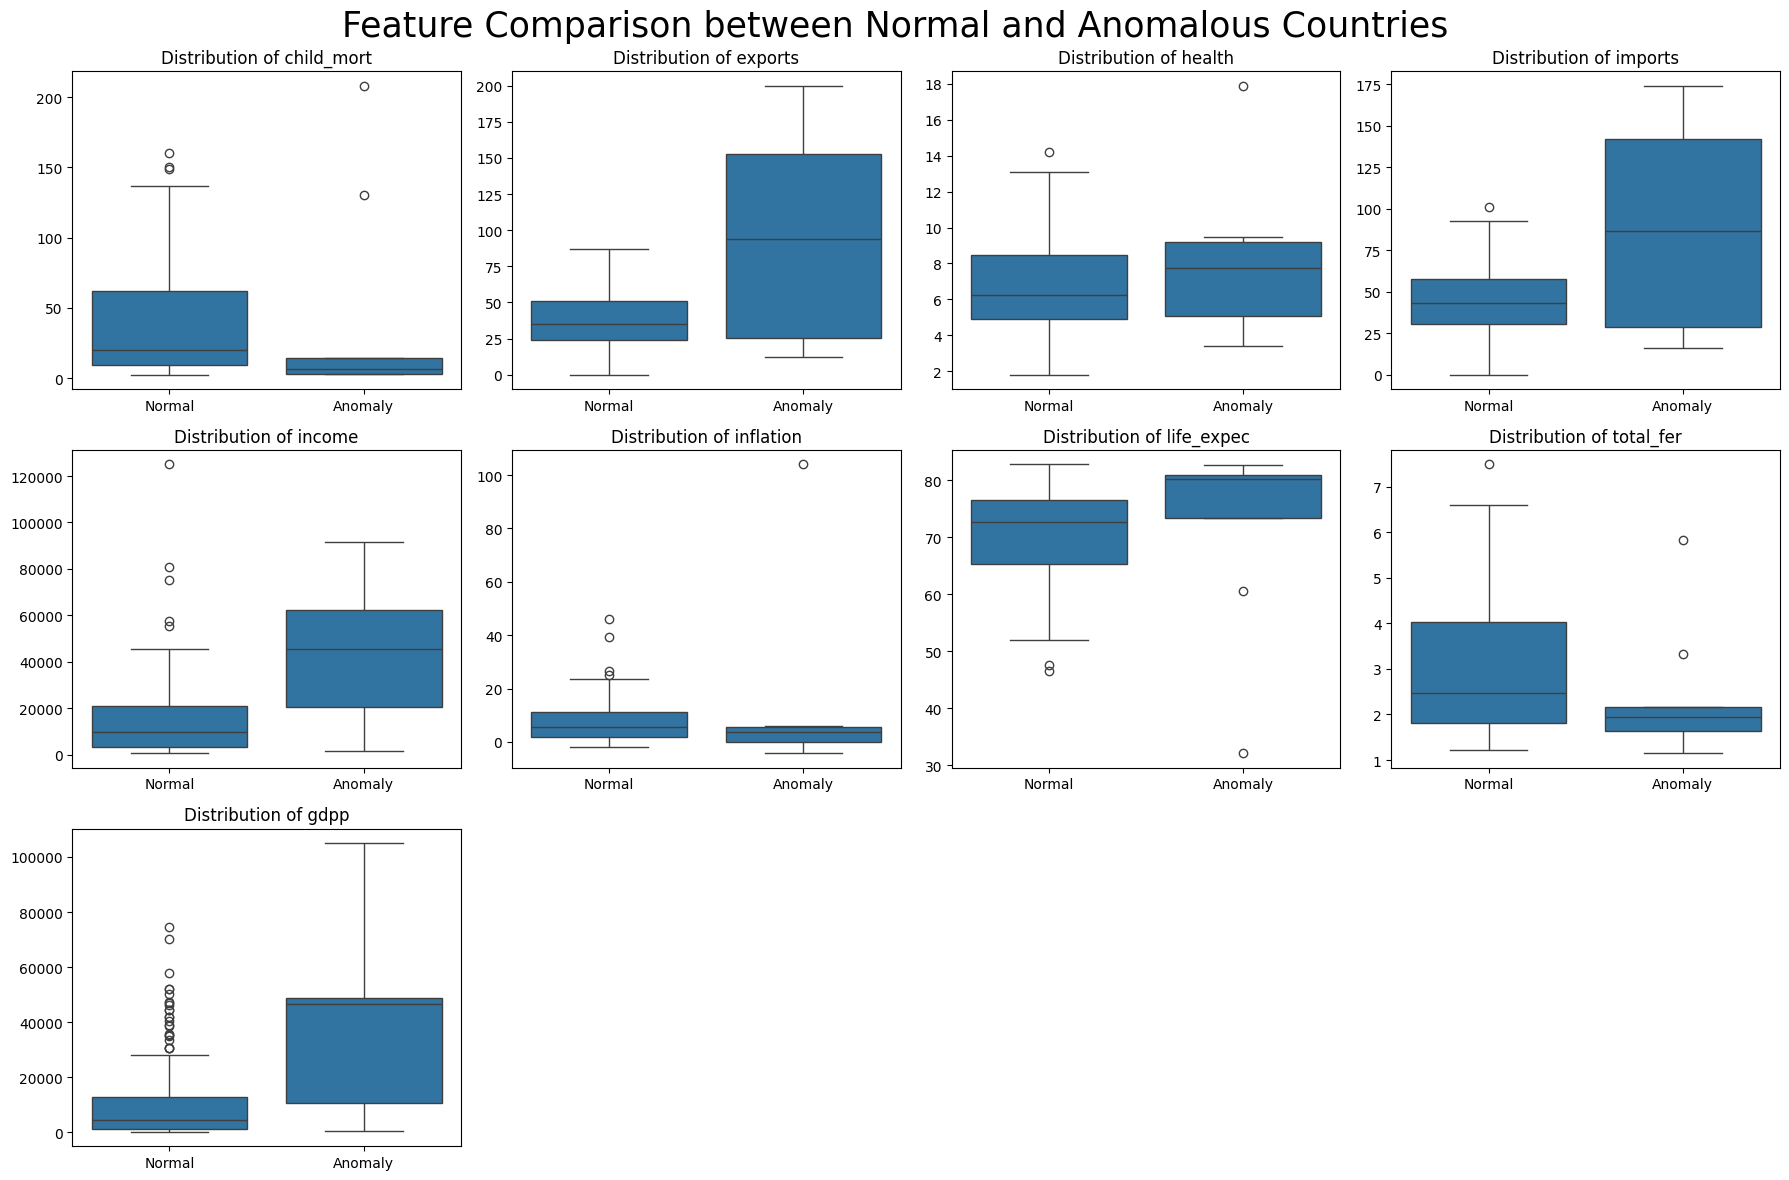

In [15]:
features_to_compare = country_df.drop(columns=['country']).columns

plt.figure(figsize=(18, 12))
plt.suptitle('Feature Comparison between Normal and Anomalous Countries', fontsize=25)


for i, feature in enumerate(features_to_compare):
    plt.subplot(3, 4, i + 1)
    sns.boxplot(x=['Anomaly' if idx in anomalous_indices else 'Normal' for idx in country_df.index],
                y=country_df[feature])
    plt.title(f'Distribution of {feature}')
    plt.xlabel('')
    plt.ylabel('')

plt.tight_layout()
plt.show()

As can be seen from the comparison of the descriptive statistics between normal and anomalous countries identified by KDE, confirmed by the box plots, normal and anomalous contries significantly vary by their imports, exports, income, and GDP socioeconomic performances.